IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score,  classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Importando os conjuntos da base de dados

In [2]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=None)
df_test = pd.read_csv(test_path, index_col=None)
df_subtrain = pd.read_csv(subtrain_path, index_col=None)

In [3]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (7200, 23)
Teste: (9000, 23)
Sub-conjunto de treinamento (28800, 23)


In [4]:
X_train_subset = df_subtrain.drop(columns=["loan_status"])
y_train_subset  = df_subtrain["loan_status"]

X_val = df_val.drop(columns=["loan_status"])
y_val = df_val["loan_status"]

X_test = df_test.drop(columns=["loan_status"])
y_test = df_test["loan_status"]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)

# Achando os melhores hiperparâmetros

In [11]:
# Modelos base
base_models = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('lightgbm', lgb.LGBMClassifier())
]

# Modelo meta
meta_model = LogisticRegression()

# Parâmetros para o RandomizedSearchCV
param_dist = {
    'final_estimator__C': [0.01, 0.1, 1, 10], 
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'saga'],
}

# Testar ambas as versões de stack_method
metodos = ['predict_proba', 'predict']
resultados = {}

for metodo in metodos:
    print(f"\n🔍 Testando stack_method='{metodo}'...")
    
    # Criar o modelo Stacking com o stack_method atual
    modelo_stacking = StackingClassifier(
        estimators=base_models, 
        final_estimator=meta_model, 
        passthrough=True,
        stack_method=metodo
    )

    # Listas para armazenar os resultados
    melhores_modelos = []
    historico_mean_scores = []
    historico_std_scores = []

    # Executar o RandomizedSearchCV 20 vezes
    for i in range(20):
        print(f"Executando RandomizedSearchCV {i+1}/20...")

        random_search = RandomizedSearchCV(
            modelo_stacking,
            param_distributions=param_dist,
            n_iter=1,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,
            random_state=i,
            scoring='accuracy',
            return_train_score=True
        )

        random_search.fit(X_train_subset, y_train_subset)

        # Média e desvio-padrão das 5 folds na validação cruzada
        mean_scores = random_search.cv_results_['mean_test_score']
        std_scores = random_search.cv_results_['std_test_score']

        historico_mean_scores.append(np.mean(mean_scores))
        historico_std_scores.append(np.mean(std_scores))

        # Melhor modelo encontrado na iteração atual
        melhores_modelos.append(random_search.best_estimator_)


    # Escolher o melhor modelo baseado na melhor acurácia no conjunto de validação
    indice_melhor = np.argmax(historico_mean_scores)
    melhor_modelo_final = melhores_modelos[indice_melhor]

    print(f"\nstack_method={metodo}")
    print(f"Melhor acurácia no conjunto de validação: {historico_mean_scores[indice_melhor]:.4f}")
    print(f"Melhores parâmetros encontrados: {random_search.best_params_}")

    # Armazenar os melhores resultados dessa versão
    resultados[metodo] = {
        "melhor_modelo": melhor_modelo_final,
        "melhores_hiperparâmetros": melhor_modelo_final.get_params(),
        "melhor_acuracia": historico_mean_scores[indice_melhor]
    }

# Comparação final
print("\nComparação final entre stack_methods:")
for metodo, res in resultados.items():
    print(f"\n🔹 stack_method={metodo}")
    print(f"Melhor Acurácia: {res['melhor_acuracia']:.4f}")
    print(f"Melhores Hiperparâmetros: {res['melhores_hiperparâmetros']}")



🔍 Testando stack_method='predict_proba'...
Executando RandomizedSearchCV 1/20...
[LightGBM] [Info] Number of positive: 6400, number of negative: 22400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Number of positive: 5120, number of negative: 17920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initsc

Plot e resultados da busca de hiperparâmetros

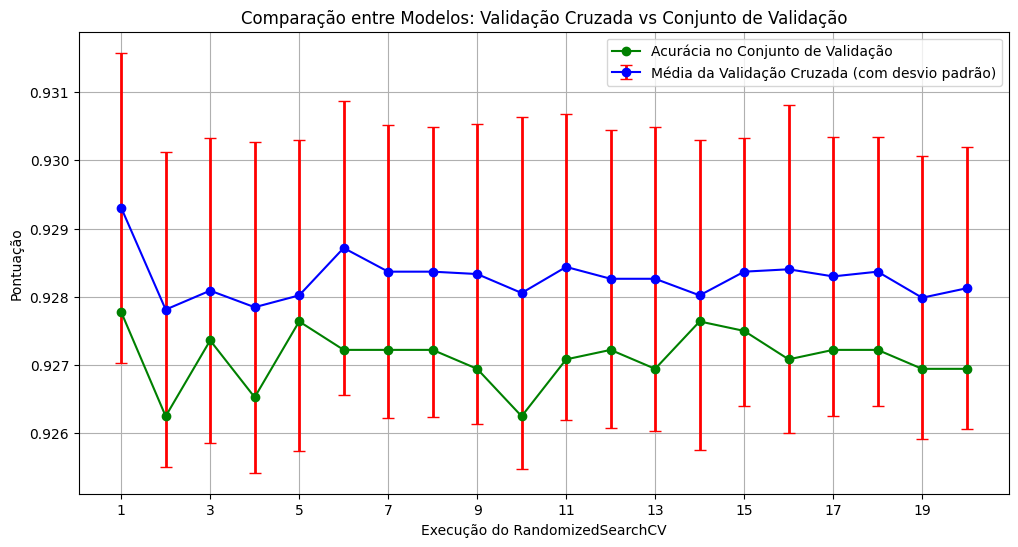

In [7]:
plt.figure(figsize=(12, 6))

plt.errorbar(
    range(1, len(historico_mean_scores) + 1), 
    historico_mean_scores, 
    yerr=historico_std_scores, 
    fmt='o-',  
    color='b', 
    ecolor='r',  
    elinewidth=2, 
    capsize=4, 
    label='Média da Validação Cruzada (com desvio padrão)'
)

plt.xlabel('Execução do RandomizedSearchCV')
plt.ylabel('Pontuação')
plt.title('Média da Validação Cruzada ao Longo das Execuções')
plt.xticks(range(1, len(historico_mean_scores) + 1, max(1, len(historico_mean_scores) // 10)))
plt.grid(True)
plt.legend()
plt.show()

# Treinando e testando o modelo

In [ ]:
# Seleciona o melhor modelo
melhor_metodo = max(resultados, key=lambda m: resultados[m]['melhor_acuracia'])
melhor_modelo_final = resultados[melhor_metodo]['melhor_modelo']

# Treina o modelo
melhor_modelo_final.fit(X_train, y_train)

# Previsões no conjunto de treinamento
y_train_pred = melhor_modelo_final.predict(X_train)

# Previsões no conjunto de teste
y_test_pred = melhor_modelo_final.predict(X_test)

# Calcula as métricas para treinamento
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='macro') 
recall_train = recall_score(y_train, y_train_pred, average='macro') 
f1_train = f1_score(y_train, y_train_pred, average='macro')

# Calcula as métricas para teste
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro') 
recall_test = recall_score(y_test, y_test_pred, average='macro') 
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Exibir os valores no console
print("Métricas no Treino:")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"Precisão: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")

print("\nMétricas no Teste:")
print(f"Acurácia: {accuracy_test:.4f}")
print(f"Precisão: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Number of positive: 6400, number of negative: 22400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[Lig

Comparando o teste e o treinamento

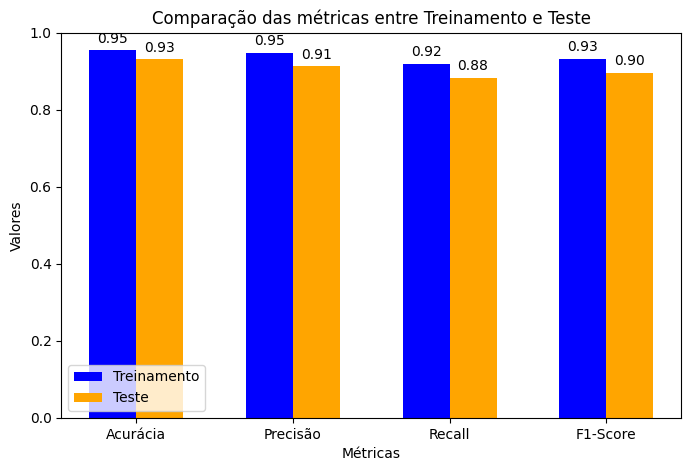

In [9]:
metricas = ["Acurácia", "Precisão", "Recall", "F1-Score"]
valores_treino = [accuracy_train, precision_train, recall_train, f1_train]
valores_teste = [accuracy_test, precision_test, recall_test, f1_test]

x = np.arange(len(metricas))
largura = 0.3

plt.figure(figsize=(8, 5))
plt.bar(x - largura/2, valores_treino, largura, label="Treinamento", color="blue")
plt.bar(x + largura/2, valores_teste, largura, label="Teste", color="orange")

plt.xlabel("Métricas")
plt.ylabel("Valores")
plt.title("Comparação das métricas entre Treinamento e Teste")
plt.xticks(x, metricas)
plt.legend()
plt.ylim(0, 1)

# Exibir valores nas barras
for i in range(len(metricas)):
    plt.text(i - largura/2, valores_treino[i] + 0.02, f"{valores_treino[i]:.2f}", ha='center', fontsize=10)
    plt.text(i + largura/2, valores_teste[i] + 0.02, f"{valores_teste[i]:.2f}", ha='center', fontsize=10)

plt.show()

Matriz de confusão


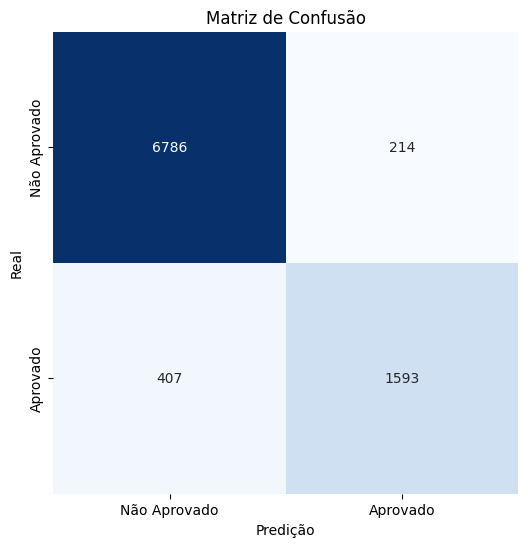

In [10]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Aprovado', 'Aprovado'], yticklabels=['Não Aprovado', 'Aprovado'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()